# sup4C

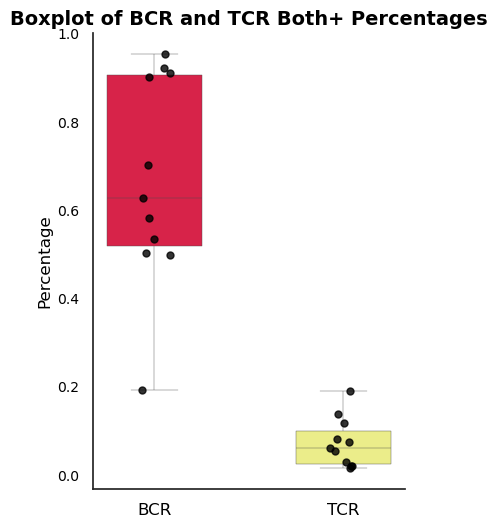

In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load and process all sample batches
adata_paths = [
    '/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047C3/test_analysis_celltype/D06047C3.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047D4/test_analysis_celltype/D06047D4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047E2/test_analysis_celltype/D06047E2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047F6/test_analysis_celltype/D06047F6.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050A2/test_analysis_celltype/D06050A2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050C2/test_analysis_celltype/D06050C2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050D4/test_analysis_celltype/D06050D4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050E4/test_analysis_celltype/D06050E4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad'
]
batch_categories = [
    "D06047A2", "D06047C3", "D06047D4", "D06047E1", "D06047E2", "D06047F6",
    "D06050A2", "D06050C2", "D06050D4", "D06050E4", "D06053D2"
]
adata_list = [sc.read_h5ad(p) for p in adata_paths]
for ad in adata_list:
    ad.var_names_make_unique()

# 2. Per-sample pairing statistics
sample_info = []
for adata, batch_name in zip(adata_list, batch_categories):
    obs = adata.obs
    # TCR & BCR pair rates
    csv = obs[(obs['TRAcdr3aa'].notna()) | (obs['TRBcdr3aa'].notna()) | (obs['IGHcdr3aa'].notna()) | (obs['IGK/Lcdr3aa'].notna())]
    TCR_pair = obs[(obs['TRAcdr3aa'].notna()) & (obs['TRBcdr3aa'].notna())].shape[0]
    TCR_all  = obs[(obs['TRAcdr3aa'].notna()) | (obs['TRBcdr3aa'].notna())].shape[0]
    TCR_rate = TCR_pair / TCR_all if TCR_all > 0 else 0
    BCR_pair = obs[(obs['IGHcdr3aa'].notna()) & (obs['IGK/Lcdr3aa'].notna())].shape[0]
    BCR_all  = obs[(obs['IGHcdr3aa'].notna()) | (obs['IGK/Lcdr3aa'].notna())].shape[0]
    BCR_rate = BCR_pair / BCR_all if BCR_all > 0 else 0

    # --- TCR+ assignment
    tcr_count = 0
    t_both = 0
    if 'TRBC1' in adata.var_names and 'TRBC2' in adata.var_names:
        tmp = adata[:, ['TRBC1', 'TRBC2']].to_df()
        tmp['TRBC'] = tmp['TRBC1'] + tmp['TRBC2']
        obs = obs.merge(tmp[['TRBC']], left_index=True, right_index=True)
        # Assign
        obs['TCR+'] = 'other'
        obs.loc[obs['TRBcdr3aa'].notna(), 'TCR+'] = 'TCR'
        obs.loc[(obs['TCR+'] == 'TCR') & (obs['TRBC'] > 0), 'TCR+'] = 'both'
        counts = obs['TCR+'].value_counts().to_dict()
        tcr_count = counts.get('TCR', 0)
        t_both = counts.get('both', 0)
    # --- BCR+ assignment
    bcr_count = 0
    b_both = 0
    if all(col in adata.var_names for col in ['IGHA1','IGHA2','IGHG1','IGHG2','IGHG3','IGHG4','IGHM','IGHD','IGHE']):
        tmp1 = adata[:, ['IGHA1','IGHA2','IGHG1','IGHG2','IGHG3','IGHG4','IGHM','IGHD','IGHE']].to_df()
        tmp1['IGHX'] = tmp1.sum(axis=1)
        obs = obs.merge(tmp1[['IGHX']], left_index=True, right_index=True)
        obs['BCR+'] = 'other'
        obs.loc[obs['IGHcdr3aa'].notna(), 'BCR+'] = 'BCR'
        obs.loc[(obs['BCR+'] == 'BCR') & (obs['IGHX'] > 0), 'BCR+'] = 'both'
        counts = obs['BCR+'].value_counts().to_dict()
        bcr_count = counts.get('BCR', 0)
        b_both = counts.get('both', 0)
    # Store all
    sample_info.append({
        "Sample": batch_name,
        "Row_Count": csv.shape[0],
        "TCR_pair_rate": TCR_rate,
        "BCR_pair_rate": BCR_rate,
        "TCR-pair-cell": TCR_pair,
        "BCR-pair-cell": BCR_pair,
        "TCR_only": tcr_count,
        "T_both": t_both,
        "BCR_only": bcr_count,
        "B_both": b_both
    })

# 3. To DataFrame and derive percent
data = pd.DataFrame(sample_info)
data['T_sum'] = data['TCR_only'] + data['T_both']
data['B_sum'] = data['BCR_only'] + data['B_both']
data['T_percent'] = data['T_both'] / data['T_sum']
data['B_percent'] = data['B_both'] / data['B_sum']
data.to_csv("sample_tcr_bcr_info.csv", index=False)

# 4. Prepare values for boxplot
bcr_vals = data['B_percent'].dropna().values
tcr_vals = data['T_percent'].dropna().values

# 5. Boxplot with jittered points
plt.figure(figsize=(4, 6))
sns.set_style('white')
sns.set_context('notebook')

sns.boxplot(
    data=[bcr_vals, tcr_vals],
    palette=['#F50538', '#FBFD79'],
    linewidth=0.3,
    width=0.5,
    fliersize=5
)
for x_pos, vals in enumerate([bcr_vals, tcr_vals]):
    x_jitter = np.random.normal(loc=x_pos, scale=0.05, size=len(vals))
    plt.scatter(x_jitter, vals, color='black', alpha=0.8, s=25, zorder=3)

plt.title('Boxplot of BCR and TCR Both+ Percentages',
          fontsize=14, fontweight='bold', color='black')
plt.xticks([0, 1], ['BCR', 'TCR'], fontsize=12, color='black')
plt.ylabel('Percentage', fontsize=12, color='black')
plt.yticks(fontsize=10, color='black')
sns.despine()
plt.grid(False)
plt.savefig('sup4C.pdf', dpi=600, bbox_inches='tight')
plt.show()

# sup4D&E

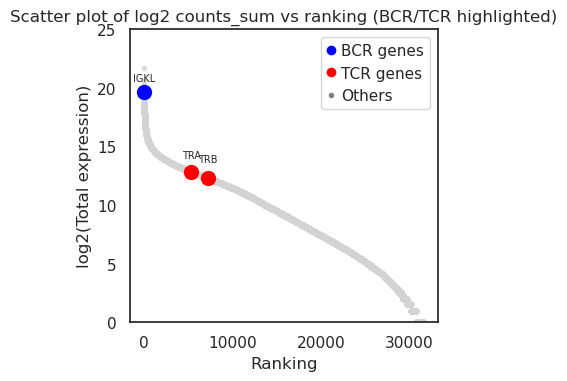

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load data and sum gene counts
adata = sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/cellbin/old/P5_D06053D2_cellbin_adjusted_scanpy_out.h5ad')
if hasattr(adata.X, "toarray"): 
    gene_counts = np.array(adata.X.sum(axis=0)).flatten()
else:  
    gene_counts = adata.X.sum(axis=0)
gene_counts_df = pd.DataFrame({'gene': adata.var_names, 'counts_sum': gene_counts})

# Collapse gene clans/isoform features
def add_sum_row(df, source_genes, new_gene):
    total = df.loc[df['gene'].isin(source_genes), 'counts_sum'].sum()
    return pd.concat(
        [df, pd.DataFrame({'gene': [new_gene], 'counts_sum': [total]})],
        ignore_index=True
    )

# BCR light chain
gene_counts_df = add_sum_row(gene_counts_df, ['IGKC','IGLC1','IGLC2','IGLC3','IGLC4','IGLC5','IGLC6','IGLC7'], 'IGKL')
# TCR alpha
gene_counts_df = add_sum_row(gene_counts_df, ['TRAC'], 'TRA')
# TCR beta
gene_counts_df = add_sum_row(gene_counts_df, ['TRBC1','TRBC2'], 'TRB')

# Rank, filter, and log2-transform
df_sorted = gene_counts_df.sort_values(by='counts_sum', ascending=False)
df_filtered = df_sorted[df_sorted['counts_sum'] != 0].reset_index(drop=True)
df_filtered['ranking'] = np.arange(1, len(df_filtered) + 1)
df_filtered['counts_sum'] = np.log2(df_filtered['counts_sum'])

# Assign highlight color/size
igh_genes = ['IGH', 'IGKL']
trbc_genes = ['TRB', 'TRA']

df_filtered['color'] = 'lightgrey'
df_filtered['size'] = 10
df_filtered.loc[df_filtered['gene'].isin(igh_genes), ['color', 'size']] = ['blue', 100]
df_filtered.loc[df_filtered['gene'].isin(trbc_genes), ['color', 'size']] = ['red', 100]

# Scatter plot: others -> IGH -> TRB (layering, for zorder)
plt.figure(figsize=(4, 4))
plt.scatter(
    df_filtered.loc[~df_filtered['gene'].isin(igh_genes + trbc_genes), 'ranking'],
    df_filtered.loc[~df_filtered['gene'].isin(igh_genes + trbc_genes), 'counts_sum'],
    c='lightgrey', s=10, alpha=0.7, zorder=1
)
plt.scatter(
    df_filtered.loc[df_filtered['gene'].isin(igh_genes), 'ranking'],
    df_filtered.loc[df_filtered['gene'].isin(igh_genes), 'counts_sum'],
    c='blue', s=100, zorder=2
)
plt.scatter(
    df_filtered.loc[df_filtered['gene'].isin(trbc_genes), 'ranking'],
    df_filtered.loc[df_filtered['gene'].isin(trbc_genes), 'counts_sum'],
    c='red', s=100, zorder=3
)

# Add gene labels for BCR/TCR
for _, row in df_filtered.iterrows():
    gene = row['gene']
    if gene in igh_genes + trbc_genes:
        y_offset = np.random.uniform(0.02, 0.05) * 25
        plt.text(
            row['ranking'],
            row['counts_sum'] + y_offset,
            gene,
            fontsize=7,
            ha='center',
            va='bottom'
        )

plt.ylim(0, 25)
plt.title('Scatter plot of log2 counts_sum vs ranking (BCR/TCR highlighted)')
plt.xlabel('Ranking')
plt.ylabel('log2(Total expression)')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BCR genes', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='TCR genes', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Others', markerfacecolor='grey', markersize=5)
]
plt.legend(handles=legend_elements)
plt.grid(False)
plt.tight_layout()
plt.savefig('sup4D.pdf')
plt.show()

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


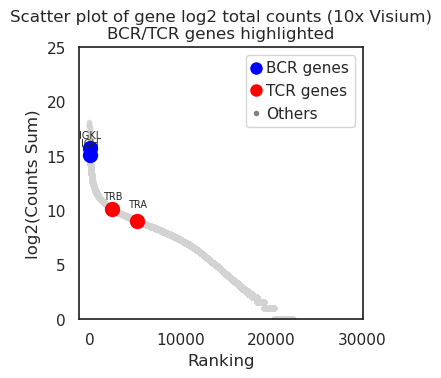

In [16]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 1. Load & sum gene expression
adata = sc.read_10x_h5('/data1/zhangyang/Method/Sup2/10X_Visium/P10_T2-filtered_feature_bc_matrix.h5')
if hasattr(adata.X, "toarray"): 
    gene_counts = np.array(adata.X.sum(axis=0)).flatten()
else:  
    gene_counts = adata.X.sum(axis=0)
gene_counts_df = pd.DataFrame({'gene': adata.var_names, 'counts_sum': gene_counts})

def add_sum_row(df, source_genes, new_gene):
    total = df.loc[df['gene'].isin(source_genes), 'counts_sum'].sum()
    return pd.concat(
        [df, pd.DataFrame({'gene': [new_gene], 'counts_sum': [total]})],
        ignore_index=True
    )

# 2. Add representative immune receptor gene classes
gene_counts_df = add_sum_row(gene_counts_df, ['IGHM', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4','IGHA1', 'IGHA2', 'IGHD', 'IGHE'], 'IGH')
gene_counts_df = add_sum_row(gene_counts_df, ['IGKC','IGLC1','IGLC2','IGLC3','IGLC4','IGLC5','IGLC6','IGLC7'], 'IGKL')
gene_counts_df = add_sum_row(gene_counts_df, ['TRAC'], 'TRA')
gene_counts_df = add_sum_row(gene_counts_df, ['TRBC1','TRBC2'], 'TRB')

# 3. Sort, rank, and log2-transform
df_sorted = gene_counts_df.sort_values(by='counts_sum', ascending=False)
df_filtered = df_sorted[df_sorted['counts_sum'] != 0].reset_index(drop=True)
df_filtered['ranking'] = np.arange(1, len(df_filtered) + 1)
df_filtered['counts_sum'] = np.log2(df_filtered['counts_sum'])

# 4. Assign highlight color/size
igh_genes = ['IGH','IGKL']
trbc_genes = ['TRB', 'TRA']

colors, sizes = [], []
for gene in df_filtered['gene']:
    if gene in igh_genes:
        colors.append('blue')
        sizes.append(100)
    elif gene in trbc_genes:
        colors.append('red')
        sizes.append(100)
    else:
        colors.append('lightgrey')
        sizes.append(10)

# 5. Scatter plot with highlight and annotation
plt.figure(figsize=(4, 4))
# Draw other genes first
mask_others = ~(df_filtered['gene'].isin(igh_genes + trbc_genes))
plt.scatter(
    df_filtered.loc[mask_others, 'ranking'],
    df_filtered.loc[mask_others, 'counts_sum'],
    c='lightgrey',
    s=10,
    alpha=0.7,
    zorder=1
)
# IGH (BCR) in blue
mask_igh = df_filtered['gene'].isin(igh_genes)
plt.scatter(
    df_filtered.loc[mask_igh, 'ranking'],
    df_filtered.loc[mask_igh, 'counts_sum'],
    c='blue',
    s=100,
    zorder=2
)
# TCR in red
mask_trbc = df_filtered['gene'].isin(trbc_genes)
plt.scatter(
    df_filtered.loc[mask_trbc, 'ranking'],
    df_filtered.loc[mask_trbc, 'counts_sum'],
    c='red',
    s=100,
    zorder=3
)

# Annotate key genes
for _, row in df_filtered.iterrows():
    gene = row['gene']
    if gene in igh_genes + trbc_genes:
        y_offset = np.random.uniform(0.02, 0.05) * 25
        plt.text(
            row['ranking'],
            row['counts_sum'] + y_offset,
            gene,
            fontsize=7,
            ha='center',
            va='bottom'
        )

plt.ylim(0, 25)
plt.xlabel('Ranking')
plt.ylabel('log2(Counts Sum)')
plt.title('Scatter plot of gene log2 total counts (10x Visium)\nBCR/TCR genes highlighted')
plt.xticks([0, 10000, 20000, 30000])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BCR genes', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='TCR genes', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Others', markerfacecolor='gray', markersize=5)
]
plt.legend(handles=legend_elements)
plt.grid(False)
plt.tight_layout()
plt.savefig('sup4E.pdf')
plt.show()

# sup4F

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


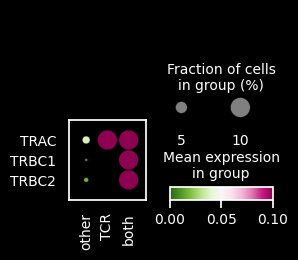

In [17]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Load AnnData
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')

# 1. Compute TRBC* summary
tmp = adata[:, ['TRBC1', 'TRBC2']].to_df()
tmp['TRBC'] = tmp['TRBC1'] + tmp['TRBC2']

# 2. Merge TRBC back to obs
adata.obs = adata.obs.join(tmp[['TRBC']])

# 3. Define TCR+ classification
adata.obs['TCR+'] = 'other'
adata.obs.loc[adata.obs['TRBcdr3aa'].notna(), 'TCR+'] = 'TCR'
adata.obs.loc[(adata.obs['TCR+'] == 'TCR') & (adata.obs['TRBC'] > 0), 'TCR+'] = 'both'

# 4. Set category ordering for groupby
adata.obs['TCR+'] = pd.Categorical(
    adata.obs['TCR+'],
    categories=['other', 'TCR', 'both'],
    ordered=True
)

# 5. Draw dotplot (dark theme)
plt.style.use('dark_background')
sc.pl.dotplot(
    adata,
    var_names=['TRAC', 'TRBC1', 'TRBC2'],
    groupby='TCR+',
    vmax=0.1,      # Adjust as needed for the expected range
    dot_max=0.1,
    swap_axes=True,
    cmap='PiYG_r',
    save='sup4F.pdf'
)

# sup4H


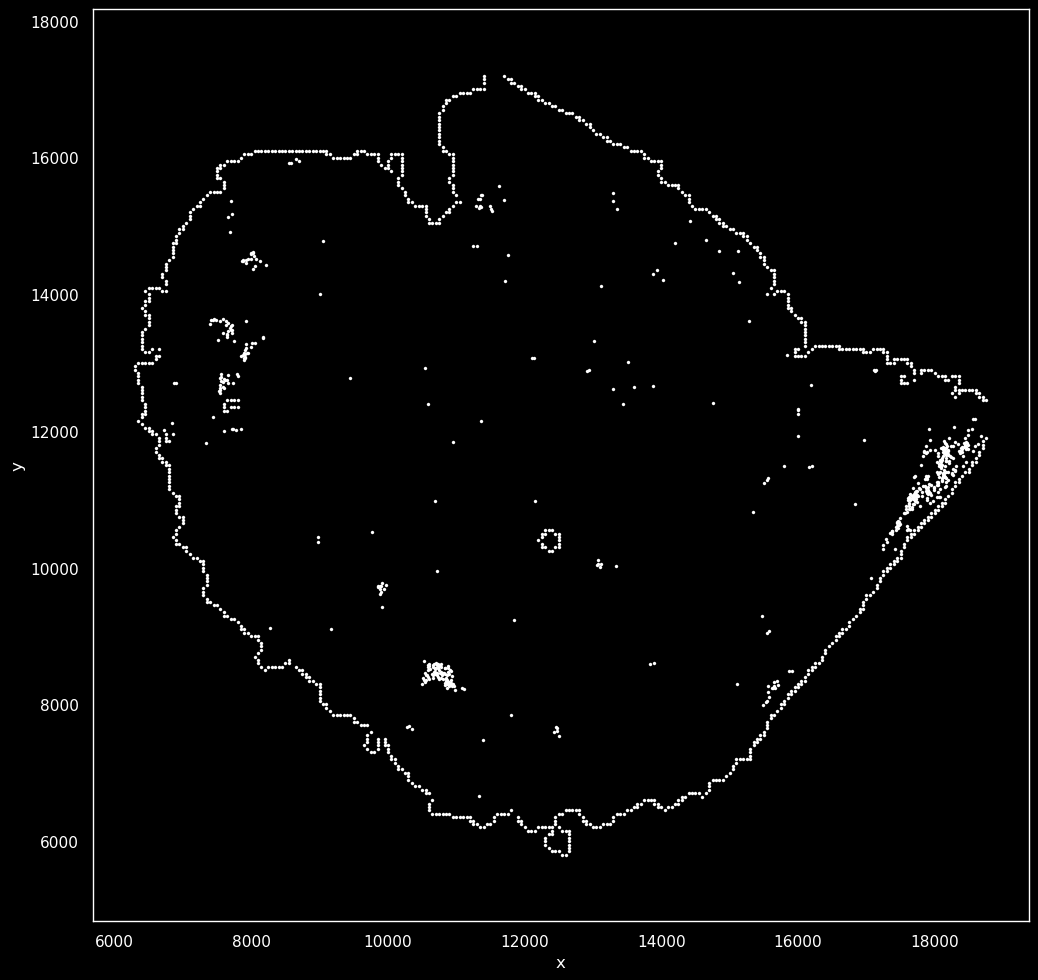

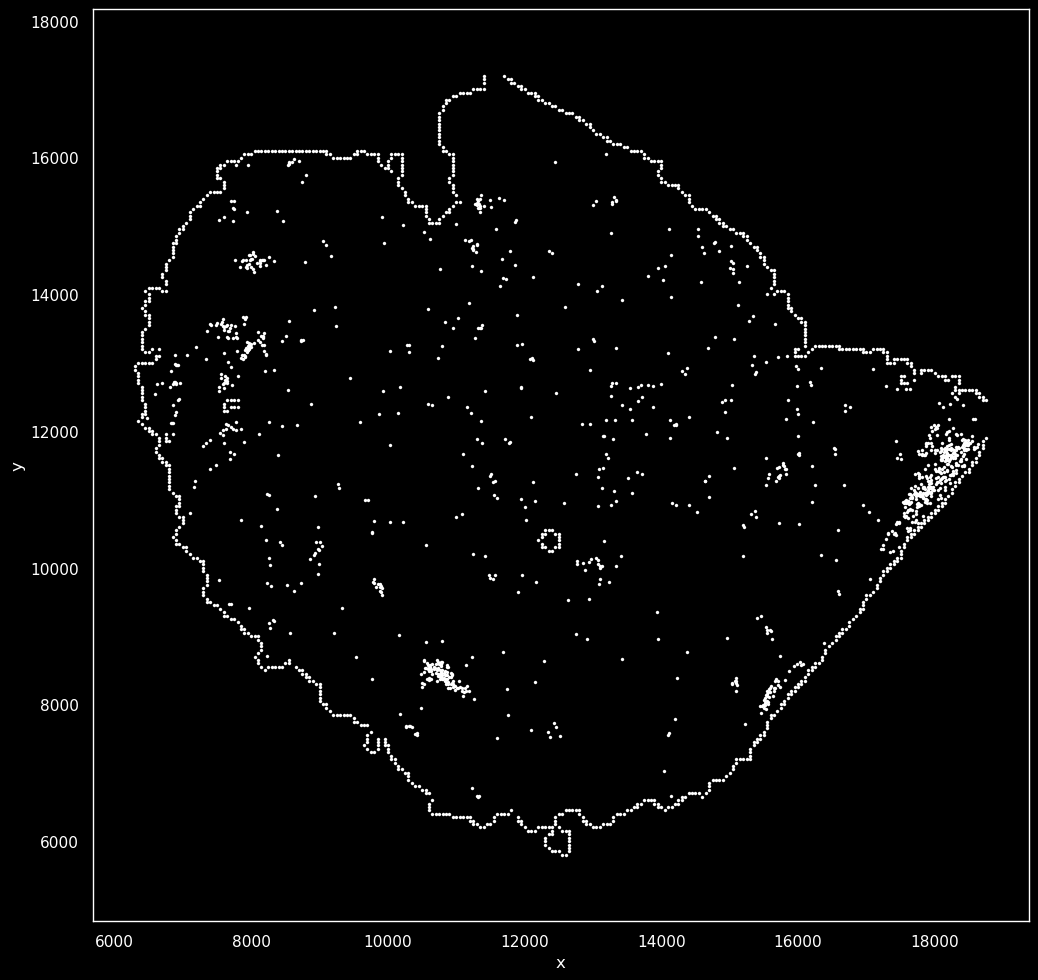

In [18]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load spatial AnnData and tissue outline
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
tissue = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])

# ------- Plot 1: Cells with TRBC (TRBC1+TRBC2) positive -------
adata.obs['TRBC1_value'] = adata[:, 'TRBC1'].to_df()
adata.obs['TRBC2_value'] = adata[:, 'TRBC2'].to_df()
adata.obs['TRBC_value'] = adata.obs['TRBC1_value'] + adata.obs['TRBC2_value']

df_trbc = adata.obs[(adata.obs['TRBC_value'] > 0) & (adata.obs['anno'] == 'Tcell')]

fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
sns.scatterplot(data=tissue, x='x', y='y', s=5, color='white', ax=ax)
sns.scatterplot(data=df_trbc, x='x', y='y', s=5, color='white', ax=ax)
plt.axis('equal')
plt.grid(False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('white')
plt.savefig('sup4H_TRBC12_overview.png', dpi=900)
plt.show()

# ------- Plot 2: Cells annotated as T cells with TRBcdr3aa -------
import numpy as np

df_tcrb = adata.obs[(adata.obs['TRBcdr3aa'].notna()) & (adata.obs['anno'] == 'Tcell')]

fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
sns.scatterplot(data=tissue, x='x', y='y', s=5, color='white', ax=ax)
sns.scatterplot(data=df_tcrb, x='x', y='y', s=5, color='white', ax=ax)
plt.axis('equal')
plt.grid(False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.tick_params(axis='both', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('white')
plt.savefig('sup4H_TCRβ_overview.png', dpi=900)
plt.show()

# sup4J

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


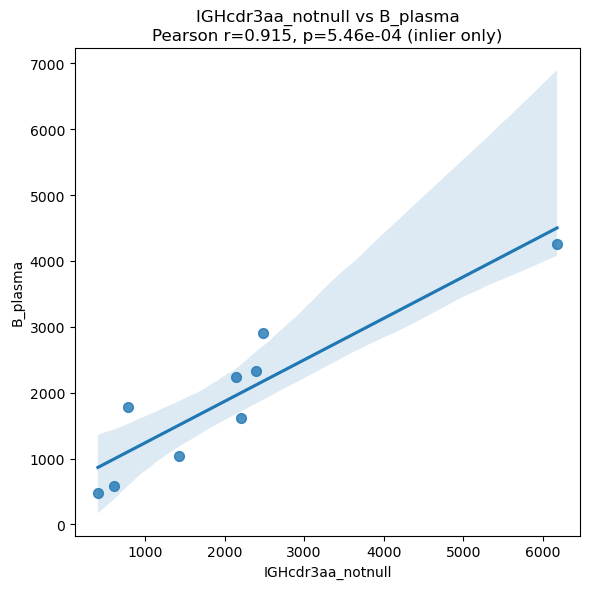

[去除回归outlier后] Pearson相关系数: 0.915，P值: 5.46e-04


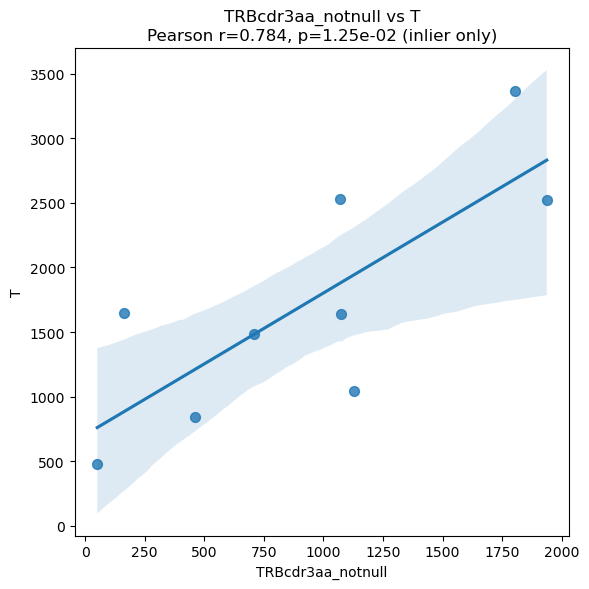

[去除回归outlier后] Pearson相关系数: 0.784，P值: 1.25e-02


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.robust.scale import mad

# --- 1. Group and summarize sample-level counts ---
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
df = adata.obs

# For each batch/sample
result_df = (
    df.groupby('batch')
    .agg(
        IGHcdr3aa_notnull=('IGHcdr3aa', lambda x: x.notna().sum()),
        TRBcdr3aa_notnull=('TRBcdr3aa', lambda x: x.notna().sum()),
        B_plasma=('anno', lambda x: (x.isin(['b_cell', 'plasma_cell'])).sum()),
        T=('anno', lambda x: (x == 'Tcell').sum())
    )
)
# print(result_df)

# --- 2. Robust regression-based inlier selection ---
def regression_residual_outlier(x, y, threshold=4):
    """
    Robust linear regression outlier detector using residuals/MAD.
    Returns (mask_inlier, resid, mad_resid)
    """
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    resid = np.abs(y - y_pred)
    mad_resid = mad(resid)
    mask_inlier = resid <= threshold * mad_resid
    return mask_inlier, resid, mad_resid

# --- 3. IGHcdr3aa_notnull vs B_plasma ---
x1 = result_df['IGHcdr3aa_notnull'].values
y1 = result_df['B_plasma'].values
mask1, resid1, mad_resid1 = regression_residual_outlier(x1, y1, threshold=4)

corr1, pval1 = pearsonr(x1[mask1], y1[mask1])
plt.figure(figsize=(6, 6))
sns.regplot(x=x1[mask1], y=y1[mask1], ci=95, scatter_kws={'s':50})
plt.xlabel('IGHcdr3aa_notnull')
plt.ylabel('B_plasma')
plt.title('IGHcdr3aa_notnull vs B_plasma\n'
          f'Pearson r={corr1:.3f}, p={pval1:.2e} (inlier only)')
plt.tight_layout()
plt.grid(False)
plt.savefig('sup4J1.pdf')
plt.show()
print(f'[去除回归outlier后] Pearson相关系数: {corr1:.3f}，P值: {pval1:.2e}')

# --- 4. TRBcdr3aa_notnull vs T ---
x2 = result_df['TRBcdr3aa_notnull'].values
y2 = result_df['T'].values
mask2, resid2, mad_resid2 = regression_residual_outlier(x2, y2, threshold=4)

corr2, pval2 = pearsonr(x2[mask2], y2[mask2])
plt.figure(figsize=(6, 6))
sns.regplot(x=x2[mask2], y=y2[mask2], ci=95, scatter_kws={'s':50})
plt.xlabel('TRBcdr3aa_notnull')
plt.ylabel('T')
plt.title('TRBcdr3aa_notnull vs T\n'
          f'Pearson r={corr2:.3f}, p={pval2:.2e} (inlier only)')
plt.tight_layout()
plt.grid(False)
plt.savefig('sup4J2.pdf')
plt.show()
print(f'[去除回归outlier后] Pearson相关系数: {corr2:.3f}，P值: {pval2:.2e}')

# sup4K

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


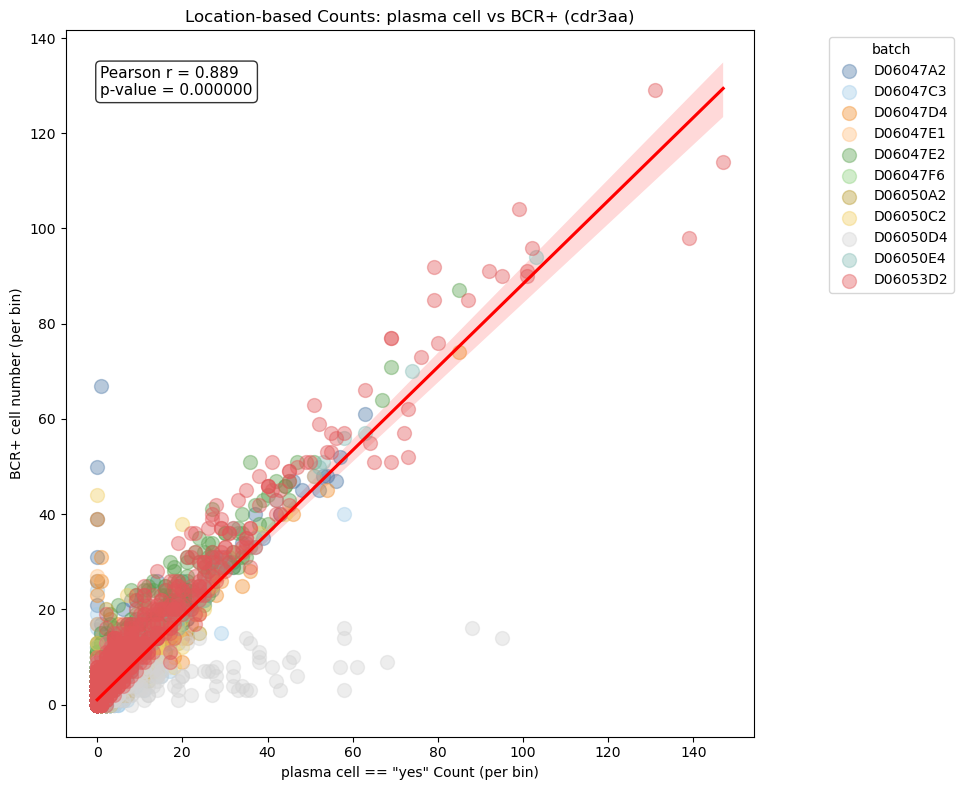

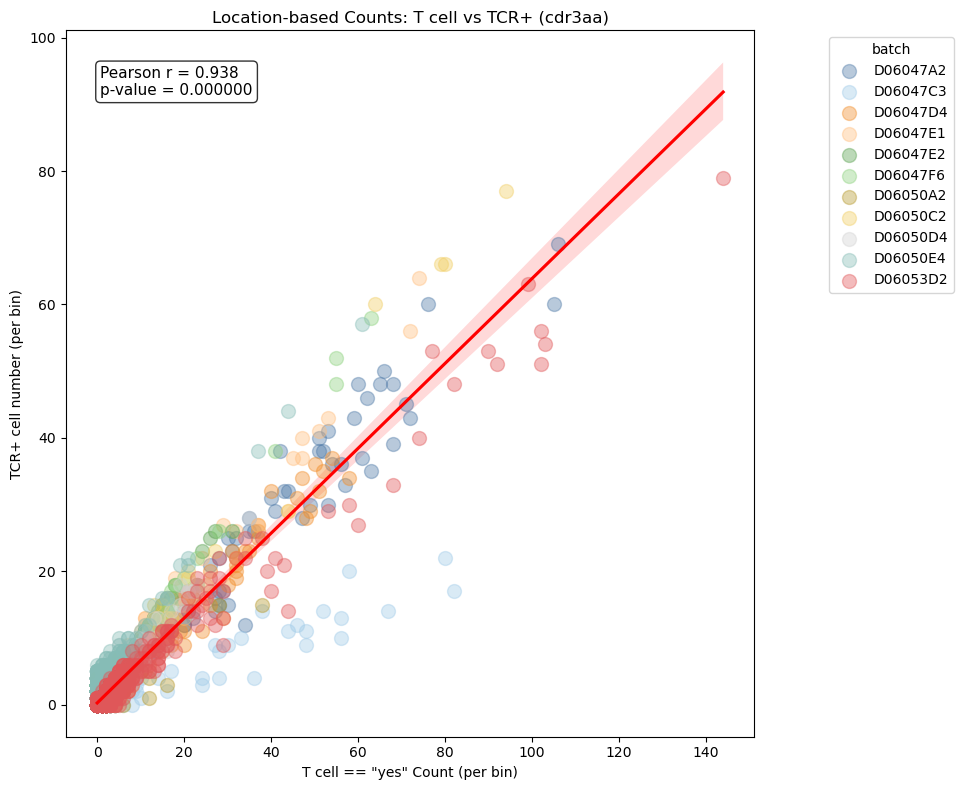

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

palette = [
    "#4E79A7", "#A0CBE8", "#F28E2B", "#FFBE7D", "#59A14F",
    "#8CD17D", "#B6992D", "#F1CE63", "lightgray", "#86BCB6", "#E15759"
]

# -------------- T cell panel (can enable output as needed) -----------------
def plot_tcell_tcr_correlation(adata):
    tmp = adata.copy()
    tmp.obs['TRAcdr3aa'] = tmp.obs['TRAcdr3aa'].astype(str)
    tmp.obs['TRBcdr3aa'] = tmp.obs['TRBcdr3aa'].astype(str)

    bs = 200
    tmp.obs['binx'] = tmp.obs['x'] // bs * bs
    tmp.obs['biny'] = tmp.obs['y'] // bs * bs
    tmp.obs['bin_loc'] = tmp.obs['batch'].astype(str) + '_' + tmp.obs['binx'].astype(str) + '_' + tmp.obs['biny'].astype(str)
    tmp.obs['Tcell'] = 'no'
    tmp.obs.loc[tmp.obs['anno'] == 'Tcell', 'Tcell'] = 'yes'

    df = tmp.obs
    cdr3_valid = lambda x: (~x.isin(['nan', 'None', '', 'NaN']))
    df['TRAorTRB_cdr3aa_valid'] = cdr3_valid(df['TRAcdr3aa']) | cdr3_valid(df['TRBcdr3aa'])

    plot_data = df.groupby('bin_loc').agg(
        tcell_count=('Tcell', lambda x: (x == 'yes').sum()),
        tcr_cdr3aa_count=('TRAorTRB_cdr3aa_valid', 'sum')
    ).reset_index()
    plot_data['batch'] = plot_data['bin_loc'].str.extract(r'(^[^_]+)')
    unique_batches = plot_data['batch'].unique()
    color_dict = {batch: palette[i % len(palette)] for i, batch in enumerate(unique_batches)}

    corr_coef, p_value = stats.pearsonr(plot_data['tcell_count'], plot_data['tcr_cdr3aa_count'])
    plt.figure(figsize=(10, 8))
    sns.regplot(
        data=plot_data, x='tcell_count', y='tcr_cdr3aa_count',
        line_kws={'color': 'red'}, scatter=False
    )
    for batch in unique_batches:
        batch_data = plot_data[plot_data['batch'] == batch]
        plt.scatter(
            batch_data['tcell_count'],
            batch_data['tcr_cdr3aa_count'],
            color=color_dict[batch],
            s=100, alpha=0.4, label=batch
        )
    plt.legend(title='batch', loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.text(
        0.05, 0.95, f'Pearson r = {corr_coef:.3f}\np-value = {p_value:.6f}',
        transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    plt.title('Location-based Counts: T cell vs TCR+ (cdr3aa)')
    plt.xlabel('T cell == "yes" Count (per bin)')
    plt.ylabel('TCR+ cell number (per bin)')
    plt.grid(False)
    plt.tight_layout()
    # plt.savefig('TCR_correlation.png', dpi=600)
    plt.show()

# -------------- Plasma cell/BCR+ panel (main figure) -----------------
def plot_plasma_bcr_correlation(adata):
    tmp = adata.copy()
    tmp.obs['IGHcdr3aa'] = tmp.obs['IGHcdr3aa'].astype(str)
    tmp.obs['IGK/Lcdr3aa'] = tmp.obs['IGK/Lcdr3aa'].astype(str)

    bs = 200
    tmp.obs['binx'] = tmp.obs['x'] // bs * bs
    tmp.obs['biny'] = tmp.obs['y'] // bs * bs
    tmp.obs['bin_loc'] = tmp.obs['batch'].astype(str) + '_' + tmp.obs['binx'].astype(str) + '_' + tmp.obs['biny'].astype(str)
    tmp.obs['plasma'] = 'no'
    tmp.obs.loc[tmp.obs['anno'] == 'plasma_cell', 'plasma'] = 'yes'

    df = tmp.obs
    cdr3_valid = lambda x: (~x.isin(['nan', 'None', '', 'NaN']))
    df['IGHorIGKL_cdr3aa_valid'] = cdr3_valid(df['IGHcdr3aa']) | cdr3_valid(df['IGK/Lcdr3aa'])

    plot_data = df.groupby('bin_loc').agg(
        plasma_cell_count=('plasma', lambda x: (x == 'yes').sum()),
        bcr_cdr3aa_count=('IGHorIGKL_cdr3aa_valid', 'sum')
    ).reset_index()
    plot_data['batch'] = plot_data['bin_loc'].str.extract(r'(^[^_]+)')
    unique_batches = plot_data['batch'].unique()
    color_dict = {batch: palette[i % len(palette)] for i, batch in enumerate(unique_batches)}

    corr_coef, p_value = stats.pearsonr(plot_data['plasma_cell_count'], plot_data['bcr_cdr3aa_count'])
    plt.figure(figsize=(10, 8))
    sns.regplot(
        data=plot_data, x='plasma_cell_count', y='bcr_cdr3aa_count',
        line_kws={'color': 'red'}, scatter=False
    )
    for batch in unique_batches:
        batch_data = plot_data[plot_data['batch'] == batch]
        plt.scatter(
            batch_data['plasma_cell_count'],
            batch_data['bcr_cdr3aa_count'],
            color=color_dict[batch],
            s=100, alpha=0.4, label=batch
        )
    plt.legend(title='batch', loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.text(
        0.05, 0.95, f'Pearson r = {corr_coef:.3f}\np-value = {p_value:.6f}',
        transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    plt.title('Location-based Counts: plasma cell vs BCR+ (cdr3aa)')
    plt.xlabel('plasma cell == "yes" Count (per bin)')
    plt.ylabel('BCR+ cell number (per bin)')
    plt.grid(False)
    plt.tight_layout()
    #plt.savefig('/data1/fengyu/methods/zy/Review/for_github/Review/Reviewer1/point6--ok/BCR_correlation.png', dpi=600)
    plt.show()

# --- MAIN ---
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')

# 先画BCR/pasma相关性主图
plot_plasma_bcr_correlation(adata)
# 如需Tcell面板，取消下行注释：
plot_tcell_tcr_correlation(adata)